# **Unsupervised Learning**



## Setup

Primero, importamos algunos módulos comunes, nos aseguramos de que MatplotLib traza las figuras en línea y preparamos una función para guardar las representaciones. 

También verificamos que Python 3.5 o posterior esté instalado (aunque Python 2.x puede funcionar, está deprecado, por lo que se recomienda encarecidamente usar Python 3), así como Scikit-Learn ≥ 0.20.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Clustering

## Introducción – Classification _vs_ Clustering

In [ ]:
from sklearn.datasets import load_iris

In [ ]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Saving figure classification_vs_clustering_plot


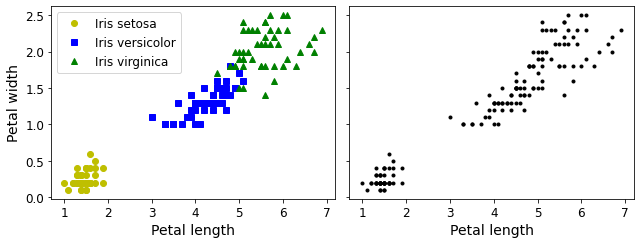

In [ ]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show()

Un Gaussian Mixtures (explicado a continuación) en realidad puede separar estos grupos bastante bien (usando las 4 características: longitud y ancho del pétalo, y longitud y ancho del sépalo).

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
mapping = np.array([2, 0, 1])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

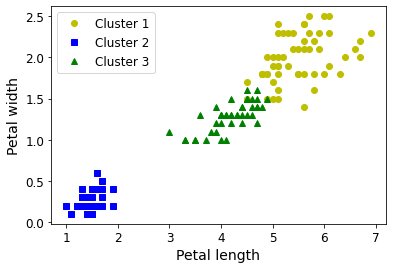

In [ ]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [ ]:
np.sum(y_pred==y)

0

In [ ]:
np.sum(y_pred==y) / len(y_pred)

0.0

## K-Means

Generemos algunos `blobs`.

In [ ]:
from sklearn.datasets import make_blobs

In [ ]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [ ]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Procedemos a representarlo:

In [ ]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Saving figure blobs_plot


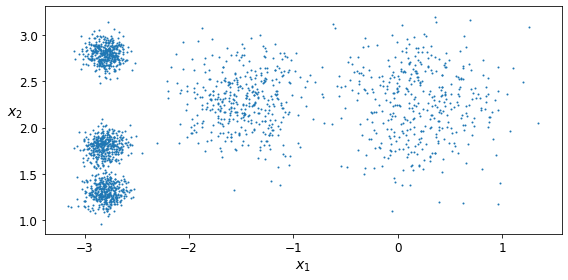

In [ ]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

### Fit _y_ Predict

Vamos a entrenar a un clúster de K-Means en este conjunto de datos. Intentará encontrar el centro de cada `blob` y asignar cada instancia al blob más cercano:

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Cada instancia se asignó a uno de los `5 grupos`:

In [ ]:
y_pred

array([4, 1, 0, ..., 3, 0, 1], dtype=int32)

In [ ]:
y_pred is kmeans.labels_

True

Y se estimaron los siguientes 5 _centroides_ (es decir, centros de agrupación):

In [ ]:
kmeans.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

Tenga en cuenta que la instancia de `KMeans` conserva las etiquetas de las instancias en las que se entrenó. Algo confuso, en este contexto, la _label_ de una instancia es el índice del clúster al que se asigna esa instancia:

In [ ]:
kmeans.labels_

array([4, 1, 0, ..., 3, 0, 1], dtype=int32)

Por supuesto, podemos predecir etiquetas de nuevas muestras.

In [ ]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 0, 3, 3], dtype=int32)

### Decision Boundaries

Tracemos los límites de decisión del modelo. Esto nos da un _Diagrama de Voronoi_:

In [ ]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_plot


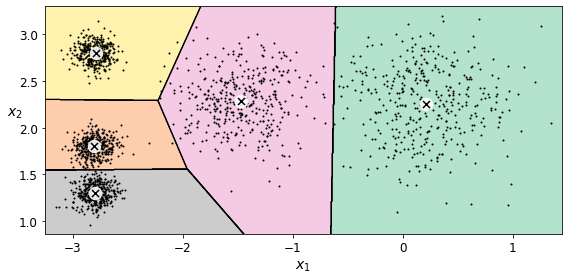

In [ ]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

¡No está mal! Algunas de las instancias cerca de los bordes probablemente se asignaron al clúster incorrecto, pero en general se ve bastante bien.

### Hard Clustering _vs_ Soft Clustering

En lugar de elegir arbitrariamente el clúster más cercano para cada instancia, que se denomina _hard clustering_, podría ser mejor medir la distancia de cada instancia a los 5 centroides. Esto es lo que hace el método `transform()`:

In [ ]:
kmeans.transform(X_new)

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

Puede verificarse que esta es realmente la distancia euclidiana entre cada instancia y cada centroide:

In [ ]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

### K-Means Algorithm

El algoritmo K-Means es uno de los algoritmos de agrupación más rápidos, pero también uno de los más simples:
* Primero inicialice $ k $ centroides al azar: se seleccionan al azar $ k $ instancias distintas del conjunto de datos y los centroides se colocan en sus ubicaciones.
* Repita hasta la convergencia (es decir, hasta que los centroides dejen de moverse):
    * Asignar cada instancia al centroide más cercano.
    * Actualice los centroides para que sean la media de las instancias que se les asignan.

La clase `KMeans` aplica un algoritmo optimizado por defecto. Para obtener el algoritmo K-Means original (solo con fines educativos), debe establecer `init ="random"`, `n_init = 1` y` algoritmo = "full" `. Estos hiperparámetros se explicarán a continuación.

Ejecutemos el algoritmo `K-Means` para 1, 2 y 3 iteraciones, para ver cómo se mueven los centroides:

In [ ]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=3, n_clusters=5,
       n_init=1, n_jobs=None, precompute_distances='auto', random_state=1,
       tol=0.0001, verbose=0)

Y vamos a representar lo siguiente:

Saving figure kmeans_algorithm_plot


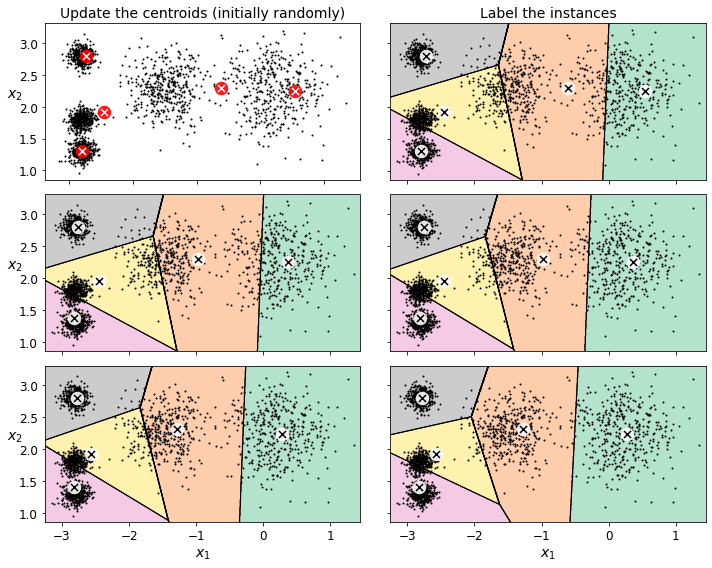

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

### K-Means Variability

En el algoritmo K-Means original, los centroides se inicializan aleatoriamente, y el algoritmo simplemente ejecuta una única iteración para mejorar gradualmente los centroides, como vimos anteriormente.

Sin embargo, un problema importante con este enfoque es que si ejecuta K-Means varias veces (o con diferentes semillas aleatorias), puede converger a soluciones muy diferentes, como puede ver a continuación:

In [ ]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Saving figure kmeans_variability_plot


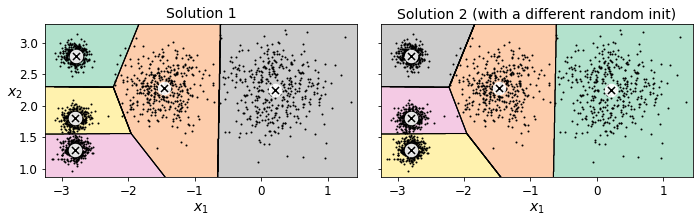

In [ ]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

### Inertia

Para seleccionar el mejor modelo, necesitaremos una forma de evaluar el rendimiento de un modelo K-Means. Desafortunadamente, la agrupación es una tarea no supervisada, por lo que no tenemos los objetivos. Pero al menos podemos medir la distancia entre cada instancia y su centroide. Esta es la idea detrás de la métrica _inertia_:

In [ ]:
kmeans.inertia_

211.5985372581684

Como puede verificar fácilmente, la inercia es la suma de las distancias al cuadrado entre cada instancia de entrenamiento y su centroide más cercano:

In [ ]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816856

El método `score()` devuelve la inercia negativa. ¿Por qué negativo? Bueno, es porque el método `score()` de un predictor siempre debe respetar la regla "_cuanto más grande, mejor_".

In [ ]:
kmeans.score(X)

-211.59853725816856

### Multiple Initializations

Entonces, un enfoque para resolver el problema de la variabilidad es simplemente ejecutar el algoritmo K-Means varias veces con diferentes inicializaciones aleatorias, y seleccionar la solución que minimice la inercia. Por ejemplo, aquí están las inercias de los dos modelos "malos" que se muestran en la figura anterior:

In [ ]:
kmeans_rnd_init1.inertia_

211.59853725816822

In [ ]:
kmeans_rnd_init2.inertia_

211.59853725816822

Como puede ver, tienen una inercia más alta que el primer modelo "bueno" que capacitamos, lo que significa que probablemente sean peores.

Cuando configura el hiperparámetro `n_init`, Scikit-Learn ejecuta el algoritmo original` n_init` veces y selecciona la solución que minimiza la inercia. Por defecto, Scikit-Learn establece `n_init = 10`.

In [ ]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=11,
       tol=0.0001, verbose=0)

Como puede ver, terminamos con el modelo inicial, que sin duda es la solución óptima de K-Means (al menos en términos de inercia, y suponiendo que $k = 5$).

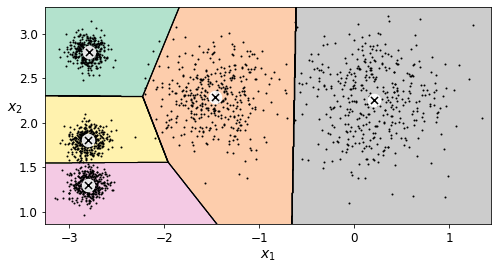

In [ ]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### K-Means++

En lugar de inicializar los centroides completamente al azar, es preferible inicializarlos usando el siguiente algoritmo, propuesto en un [artículo de 2006](https://goo.gl/eNUPw6) por David Arthur y Sergei Vassilvitskii:
* Tome un centroide $c_1$, elegido uniformemente al azar del conjunto de datos.
* Tome un nuevo centro $c_i$, eligiendo una instancia $ \mathbf {x} _i $ con probabilidad: $ D(\mathbf {x}_i)^2 $ / $ \sum \limits_{j = 1}^{m }{D(\mathbf {x}_j)}^2 $ donde $ D (\mathbf {x}_i) $ es la distancia entre la instancia $ \mathbf {x}_i $ y el centroide más cercano que ya se eligió. Esta distribución de probabilidad garantiza que las instancias que están más lejos de los centroides ya elegidos sean mucho más probables como centroides.
* Repita el paso anterior hasta que se hayan elegido todos los centroides $ k $.

El resto del algoritmo K-Means ++ es solo K-Means normal. Con esta inicialización, es mucho menos probable que el algoritmo K-Means converja a una solución subóptima, por lo que es posible reducir `n_init` considerablemente. La mayoría de las veces, esto compensa en gran medida la complejidad adicional del proceso de inicialización.

Para establecer la inicialización en K-Means ++, simplemente configure `init =" k-means++ "` (esto es realmente el valor predeterminado):

In [ ]:
KMeans()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

### Accelerated K-Means

El algoritmo K-Means puede acelerarse significativamente evitando muchos cálculos de distancia innecesarios: esto se logra explotando la desigualdad del triángulo (dados tres puntos A, B y C, la distancia AC es siempre tal que AC ≤ AB + BC) y manteniendo seguimiento de los límites inferior y superior para distancias entre instancias y centroides (consulte este [documento de 2003](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) de Charles Elkan para obtener más detalles).

Para usar la variante de K-Means de Elkan, simplemente configure `algoritmo ="elkan"`. Tenga en cuenta que no admite datos dispersos, por lo que, de forma predeterminada, Scikit-Learn usa `"elkan"` para datos densos y `"full"` (el algoritmo K-Means normal) para datos dispersos.

In [ ]:
%timeit -n 50 KMeans(algorithm="elkan").fit(X)

50 loops, best of 3: 87.1 ms per loop


In [ ]:
%timeit -n 50 KMeans(algorithm="full").fit(X)

50 loops, best of 3: 124 ms per loop


### Mini-Batch K-Means

Scikit-Learn también implementa una variante del algoritmo K-Means que admite mini lotes (consulte [este documento](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [ ]:
minibatch_kmeans.inertia_

211.93186531476775

Si el conjunto de datos no cabe en la memoria, la opción más simple es usar la clase `memmap`, tal como lo hicimos para PCA incremental en el capítulo anterior. Primero carguemos MNIST:

In [ ]:
import urllib
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

A continuación, escribámoslo en un `memmap`:

In [ ]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [ ]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

Si sus datos son tan grandes que no puede usar `memmap`, las cosas se vuelven más complicadas. Comencemos escribiendo una función para cargar el próximo lote (en la vida real, cargaría los datos del disco):


In [ ]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Ahora podemos entrenar al modelo al alimentarlo un lote a la vez. También necesitamos implementar múltiples inicializaciones y mantener el modelo con la menor inercia:

In [ ]:
np.random.seed(42)

In [ ]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [ ]:
best_kmeans.score(X)

-211.70999744411483

Mini-batch K-Means es mucho más rápido que regular K-Means:

In [ ]:
%timeit KMeans(n_clusters=5).fit(X)

10 loops, best of 3: 47.7 ms per loop


In [ ]:
%timeit MiniBatchKMeans(n_clusters=5).fit(X)

10 loops, best of 3: 27.7 ms per loop


¡Eso es *mucho* más rápido! Sin embargo, su rendimiento es a menudo más bajo (mayor inercia), y se sigue degradando a medida que aumenta _k_. Tracemos la relación de inercia y la relación de tiempo de entrenamiento entre K-Means Mini-batch y K-Means regulares:

In [ ]:
from timeit import timeit

In [ ]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

Saving figure minibatch_kmeans_vs_kmeans


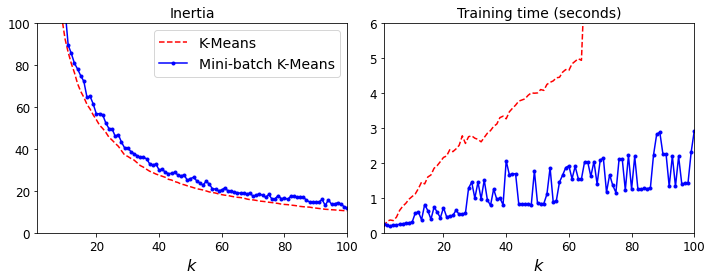

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

### Encontrando el número óptimo de clusters 

¿Qué sucede si el número de clústeres se estableció en un valor menor o mayor que 5?

Saving figure bad_n_clusters_plot


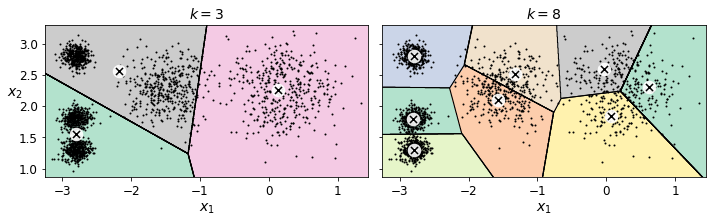

In [ ]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

No sé Rick, estos modelos parecen reguleros.

In [ ]:
kmeans_k3.inertia_

653.2167190021553

In [ ]:
kmeans_k8.inertia_

118.41983763508077

No, no podemos simplemente tomar el valor de $ k $ que minimiza la inercia, ya que sigue bajando a medida que aumentamos $ k $. De hecho, cuantos más grupos haya, más cerca estará cada instancia de su centroide más cercano y, por lo tanto, menor será la inercia. Sin embargo, podemos trazar la inercia en función de $ k $ y analizar la curva resultante:

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Saving figure inertia_vs_k_plot


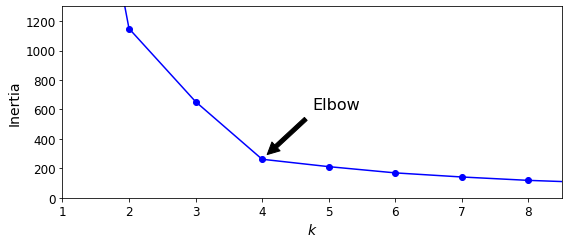

In [ ]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

Como se puede ver, hay un codo en $ k = 4 $, lo que significa que menos grupos que eso serían malos, y más grupos no ayudarían mucho y podrían cortar los grupos a la mitad. Entonces $ k = 4 $ es una muy buena opción. Por supuesto, en este ejemplo no es perfecto ya que significa que los dos blobs en la parte inferior izquierda se considerarán como un solo clúster, pero no obstante es un buen agrupamiento.

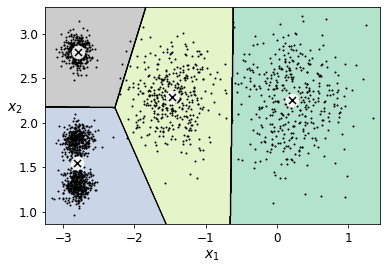

In [ ]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Otro enfoque consiste en observar el `silhouette_score`, que es el coeficiente medio de silueta en todas las instancias. El `silhouette_score` de una instancia es igual a $ (b - a) / \max (a, b) $ donde $ a $ es la distancia media a las otras instancias en el mismo grupo (es la _mena distancia intra-grupo_), y $ b $ es la _mean distancia del grupo más cercano_, es decir, la distancia media a las instancias del siguiente grupo más cercano (definido como el que minimiza $ b $, excluyendo el propio grupo de la instancia). 

El `silhouette_score` puede variar entre -1 y +1: un coeficiente cercano a +1 significa que la instancia está bien dentro de su propio grupo y lejos de otros grupos, mientras que un coeficiente cercano a 0 significa que está cerca de un límite de grupo, y finalmente un coeficiente cercano a -1 significa que la instancia puede haber sido asignada al clúster incorrecto.

Vamos a representar el silhouette score como función de $k$:

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [ ]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


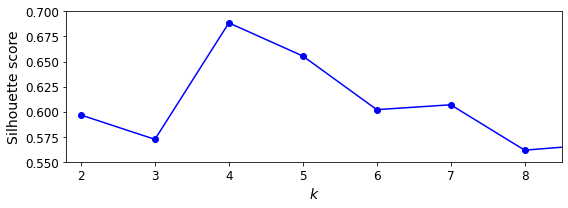

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

Como puede ver, esta visualización es mucho más rica que la anterior: en particular, aunque confirma que $ k = 4 $ es una muy buena opción, pero también subraya el hecho de que $ k = 5 $ también es bastante bueno .

Se proporciona una visualización aún más informativa cuando traza el coeficiente de silueta de cada instancia, ordenado por el grupo al que están asignados y por el valor del coeficiente. Esto se llama un diagrama de silueta:

Saving figure silhouette_analysis_plot


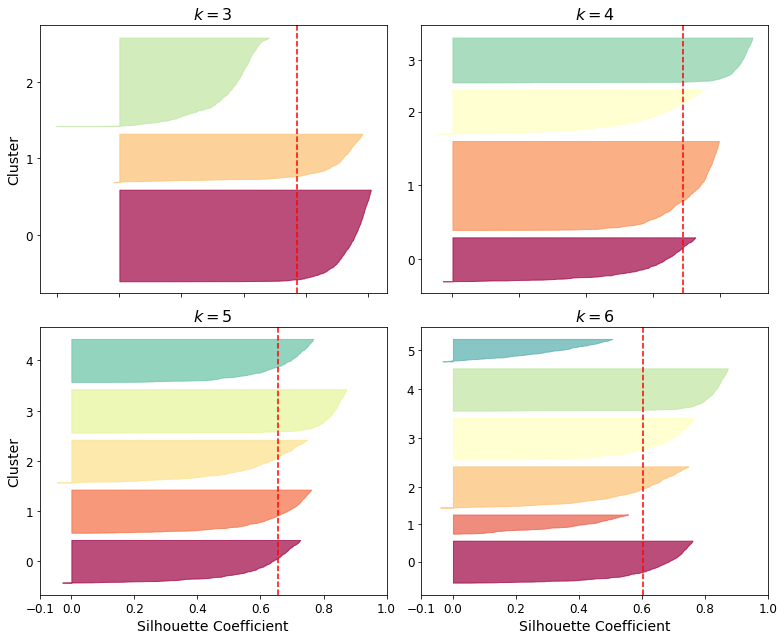

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

### Limits of K-Means

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

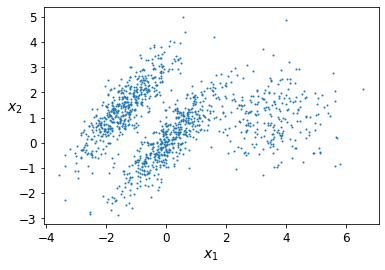

In [ ]:
plot_clusters(X)

In [ ]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

Saving figure bad_kmeans_plot


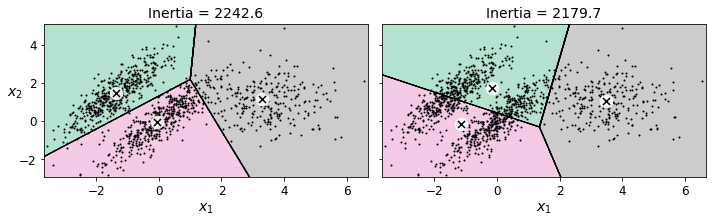

In [ ]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

### Usando clustering para image segmentation

In [ ]:
# Download the ladybug image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/unsupervised_learning/ladybug.png',
 <http.client.HTTPMessage at 0x7fde57bf14a8>)

In [ ]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

In [ ]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [ ]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

Saving figure image_segmentation_diagram


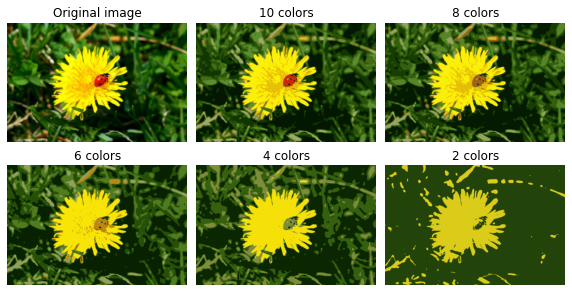

In [ ]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

### Usando Clustering para Preprocessing

Abordemos el _digit dataset_, que es un conjunto de datos simple similar a MNIST que contiene 1.797 imágenes en escala de grises de 8×8 que representan dígitos del 0 al 9.

In [ ]:
from sklearn.datasets import load_digits

In [ ]:
X_digits, y_digits = load_digits(return_X_y=True)

Dividimos nuestra muestra en `train` y `test` dataset.


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Ahora vamos a ajustar un modelo de Regresión logística y evaluarlo en el conjunto de prueba:

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
log_reg.score(X_test, y_test)

0.9688888888888889

De acuerdo, esa es nuestra línea de base: 96.89% de precisión. Veamos si podemos hacerlo mejor usando K-Means como un paso de preprocesamiento. Crearemos una tubería que primero agrupará el conjunto de entrenamiento en 50 grupos y reemplazará las imágenes con sus distancias a los 50 grupos, luego aplicaremos un modelo de regresión logística:

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=50, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=42,
                        tol=0.0001, verbose=0)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=5000,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
pipeline.score(X_test, y_test)

0.98

In [ ]:
1 - (1 - 0.977777) / (1 - 0.968888)

0.28570969400874346

¿Qué ha pasado aquí? ¡Redujimos la tasa de error en más del 28%! Pero elegimos el número de clústeres $ k $ completamente arbitrariamente, seguramente podemos hacerlo mejor. 

Dado que K-Means es solo un paso de preprocesamiento en un pipeline de clasificación, encontrar un buen valor para $ k $ es mucho más simple que antes: no es necesario realizar un silhouette analysis o minimizar la inercia, el mejor valor de $ k $ es simplemente el uno que resulte en el mejor rendimiento de clasificación.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.3s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.3s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.3s
[CV] kmeans__n_clusters=4 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed: 25.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=50, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=42, tol=0.0001,
                                               verbose=0)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                      

Veamos cuál es el mejor número de `clusters`:

In [ ]:
grid_clf.best_params_

{'kmeans__n_clusters': 57}

In [ ]:
grid_clf.score(X_test, y_test)

0.98

### Clustering for Semi-supervised Learning

Otro caso de uso para la agrupación es en el aprendizaje semi-supervisado, cuando tenemos muchas instancias sin etiquetar y muy pocas instancias etiquetadas.

Veamos el rendimiento de un modelo de regresión logística cuando solo tenemos `50 instancias` etiquetadas:

In [ ]:
n_labeled = 50

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

Es mucho menos que antes, por supuesto. Veamos cómo podemos hacerlo mejor. 

Primero, agrupemos el conjunto de entrenamiento en 50 grupos, luego para cada grupo busquemos la imagen más cercana al centroide. Llamaremos a estas imágenes imágenes representativas:

In [ ]:
k = 50

In [ ]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Ahora vamos a trazar estas imágenes representativas y etiquetarlas manualmente:

Saving figure representative_images_diagram


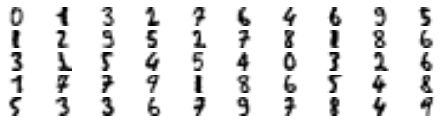

In [ ]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [ ]:
y_representative_digits = np.array([
    0, 1, 3, 2, 7, 6, 4, 6, 9, 5,
    1, 2, 9, 5, 2, 7, 8, 1, 8, 6,
    3, 1, 5, 4, 5, 4, 0, 3, 2, 6,
    1, 7, 7, 9, 1, 8, 6, 5, 4, 8,
    5, 3, 3, 6, 7, 9, 7, 8, 4, 9])

Ahora tenemos un conjunto de datos con solo 50 instancias etiquetadas, pero en lugar de ser instancias completamente aleatorias, cada una de ellas es una imagen representativa de su clúster. Veamos si el rendimiento es mejor:

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9244444444444444

Saltamos del 83.3% de precisión al 92.4%, aunque todavía solo estamos entrenando el modelo en 50 instancias. Dado que a menudo es costoso y doloroso etiquetar instancias, especialmente cuando los expertos deben hacerlo manualmente, es una buena idea hacer que etiqueten instancias representativas en lugar de solo instancias aleatorias.

Pero tal vez podamos ir un paso más allá: ¿qué pasa si propagamos las etiquetas a todas las demás instancias en el mismo clúster?

In [ ]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
log_reg.score(X_test, y_test)

0.9377777777777778

Obtuvimos un pequeño aumento de precisión. Mejor que nada, pero probablemente deberíamos haber propagado las etiquetas solo a las instancias más cercanas al centroide, porque al propagarnos al grupo completo, ciertamente habremos incluido algunos valores atípicos. Solo propaguemos las etiquetas al percentil 20 más cercano al centroide:

In [ ]:
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [ ]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
log_reg.score(X_test, y_test)

0.9222222222222223

Con solo 50 instancias etiquetadas (¡solo 5 ejemplos por clase en promedio!), Obtuvimos un rendimiento del 94%, que está bastante cerca del rendimiento de la regresión logística en el conjunto de datos _digits_ totalmente etiquetado (que fue del 96.9%).

Esto se debe a que las etiquetas propagadas son bastante buenas: su precisión es muy cercana al 99%:

In [ ]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9896193771626297

Ahora podría hacer algunas iteraciones de *aprendizaje activo*:
1. Etiquete manualmente las instancias de las que el clasificador está menos seguro, si es posible seleccionándolas en distintos grupos.
2. Entrene a un nuevo modelo con estas etiquetas adicionales.

## DBSCAN

In [ ]:
from sklearn.datasets import make_moons

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [ ]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

In [ ]:
len(dbscan.core_sample_indices_)

808

In [ ]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [ ]:
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

In [ ]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [ ]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [ ]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

Saving figure dbscan_plot


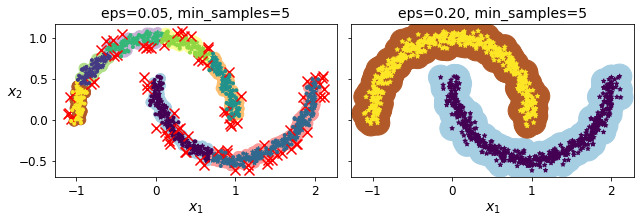

In [ ]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()


In [ ]:
dbscan = dbscan2

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [ ]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [ ]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Saving figure cluster_classification_plot


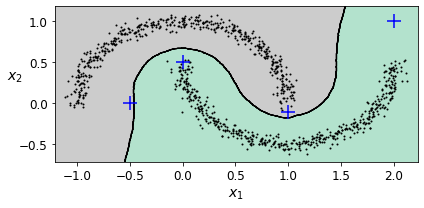

In [ ]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

In [ ]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

## Otros algoritmos de Clustering

### Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering

In [ ]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=100,
                   kernel_params=None, n_clusters=2, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10, random_state=42)

In [ ]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1,
                   kernel_params=None, n_clusters=2, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10, random_state=42)

In [ ]:
np.percentile(sc1.affinity_matrix_, 95)

0.04251990648936265

In [ ]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

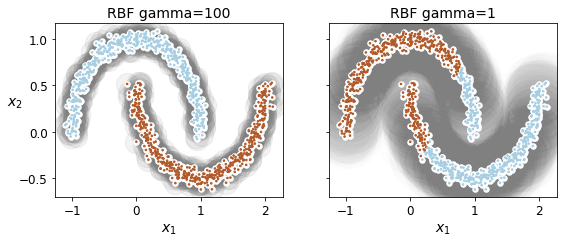

In [ ]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()


### Agglomerative Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [ ]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [ ]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_components_',
 'n_connected_components_',
 'n_leaves_']

In [ ]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

# Gaussian Mixtures

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Vamos a entrenar un modelo de Gaussian Mixture en el conjunto de datos anterior:

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Veamos los parámetros que estimó el algoritmo EM:

In [ ]:
gm.weights_

array([0.39032584, 0.20961444, 0.40005972])

In [ ]:
gm.means_

array([[ 0.05145113,  0.07534576],
       [ 3.39947665,  1.05931088],
       [-1.40764129,  1.42712848]])

In [ ]:
gm.covariances_

array([[[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]]])

¿Ha convergido el algoritmo?

In [ ]:
gm.converged_

True

Sí, ha convergido. ¿Cuántas iteraciones le ha llevado alcanzar la convergencia?

In [ ]:
gm.n_iter_

4

Ahora puede usar el modelo para predecir a qué grupo pertenece cada instancia (hard clustering) o las probabilidades de que provenga de cada grupo. Para esto, simplemente use el método `predict()` o el método `predict_proba()`:

In [ ]:
gm.predict(X)

array([0, 0, 2, ..., 1, 1, 1])

In [ ]:
gm.predict_proba(X)

array([[9.76815996e-01, 2.31833274e-02, 6.76282339e-07],
       [9.82914418e-01, 1.64110061e-02, 6.74575575e-04],
       [7.52377580e-05, 1.99781831e-06, 9.99922764e-01],
       ...,
       [4.31902443e-07, 9.99999568e-01, 2.12540639e-26],
       [5.20915318e-16, 1.00000000e+00, 1.45002917e-41],
       [2.30971331e-15, 1.00000000e+00, 7.93266114e-41]])

Este es un modelo generativo, por lo que puede probar nuevas instancias a partir de él (y obtener sus etiquetas):

In [ ]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.86951041, -0.32742378],
       [ 0.29854504,  0.28307991],
       [ 1.84860618,  2.07374016],
       [ 3.98304484,  1.49869936],
       [ 3.8163406 ,  0.53038367],
       [-1.04030781,  0.78655831]])

In [ ]:
y_new

array([0, 0, 1, 1, 1, 2])

Observe que se muestrean secuencialmente de cada grupo.

También puede estimar el registro de la _función de densidad de probabilidad_ (PDF) en cualquier ubicación utilizando el método `score_samples()`:

In [ ]:
gm.score_samples(X)

array([-2.60786904, -3.57094519, -3.3302143 , ..., -3.51359636,
       -4.39793229, -3.80725953])

Verifiquemos que el PDF se integre a 1 en todo el espacio. Simplemente tomamos un cuadrado grande alrededor de los grupos y lo cortamos en una cuadrícula de cuadrados pequeños, luego calculamos la probabilidad aproximada de que las instancias se generarán en cada cuadrado pequeño (multiplicando el PDF en una esquina del cuadrado pequeño por área del cuadrado), y finalmente sumando todas estas probabilidades). El resultado está muy cerca de 1:

In [ ]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999225099

Ahora vamos a representar los límites de decisión resultantes (líneas discontinuas) y los contornos de densidad:

In [ ]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure gaussian_mixtures_plot


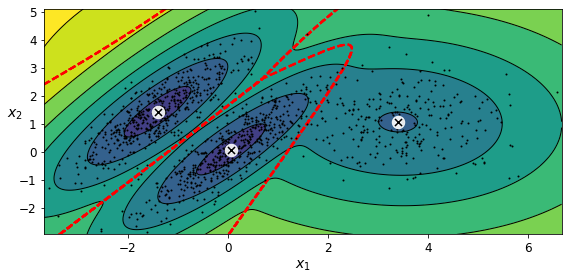

In [ ]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("gaussian_mixtures_plot")
plt.show()

Puede imponer restricciones en las matrices de covarianza que busca el algoritmo estableciendo el hiperparámetro `covariance_type`:
* `"full"` (predeterminado): sin restricciones, todos los clústeres pueden adoptar cualquier forma elipsoidal de cualquier tamaño.
* `"tied"`: todos los grupos deben tener la misma forma, que puede ser cualquier elipsoide (es decir, todos comparten la misma matriz de covarianza).
* `"spherical"`: todos los grupos deben ser esféricos, pero pueden tener diferentes diámetros (es decir, diferentes variaciones).
* `"diag"`: los grupos pueden adoptar cualquier forma elipsoidal de cualquier tamaño, pero los ejes del elipsoide deben ser paralelos a los ejes (es decir, las matrices de covarianza deben ser diagonales).

In [ ]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [ ]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


Saving figure covariance_type_plot


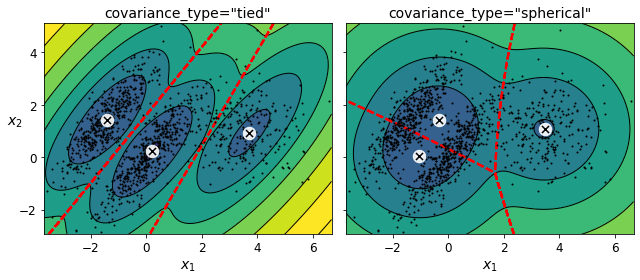

In [ ]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

save_fig("covariance_type_plot")
plt.show()

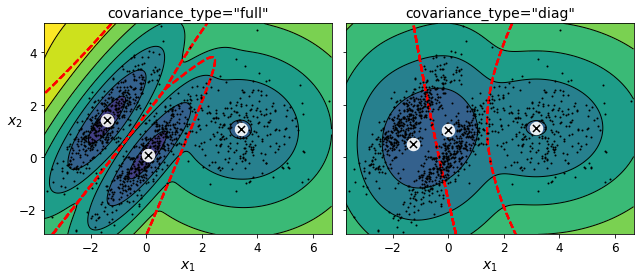

In [ ]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## Detección de anomalías usando Gaussian Mixtures

Gaussian Mixtures pueden usarse para la detección de anomalías: las instancias ubicadas en regiones de baja densidad pueden considerarse anomalías. Debe definir qué umbral de densidad desea usar. Por ejemplo, en una empresa de fabricación que intenta detectar productos defectuosos, la proporción de productos defectuosos es generalmente conocida. Digamos que es igual al 4%, luego puede establecer el umbral de densidad como el valor que resulta en tener 4% de las instancias ubicadas en áreas por debajo de esa densidad umbral:

In [ ]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

Saving figure mixture_anomaly_detection_plot


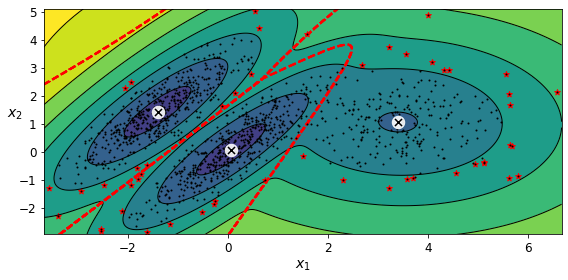

In [ ]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

## Selección del Modelo

No podemos usar la inercia o la puntuación de la silueta porque ambos suponen que los grupos son esféricos. En cambio, podemos intentar encontrar el modelo que minimice un criterio de información teórico como el Criterio de información bayesiano (BIC) o el Criterio de información de Akaike (AIC):

$ {BIC} = {\log (m) p - 2 \ log ({\hat L})} $

$ {AIC} = 2p - 2 \log (\hat L) $

* $ m $ es el número de instancias.
* $ p $ es el número de parámetros aprendidos por el modelo.
* $ \hat L $ es el valor maximizado de la función de probabilidad del modelo. Esta es la probabilidad condicional de los datos observados $ \mathbf {X} $, dado el modelo y sus parámetros optimizados.

Tanto BIC como AIC penalizan los modelos que tienen más parámetros para aprender (por ejemplo, más grupos) y premian los modelos que se ajustan bien a los datos (es decir, los modelos que dan una alta probabilidad a los datos observados).

In [ ]:
gm.bic(X)

8189.733705221635

In [ ]:
gm.aic(X)

8102.508425106597

Podríamos calcular el BIC manualmente de esta manera:

In [ ]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [ ]:
bic, aic

(8189.733705221635, 8102.508425106597)

In [ ]:
n_params

17

Hay un peso por grupo, pero la suma debe ser igual a 1, por lo que tenemos un grado de libertad menos, de ahí el -1. De manera similar, los grados de libertad para una matriz de covarianza $ n \ times n $ no son $ n ^ 2 $, sino $ 1 + 2 + \dots + n = \dfrac {n (n + 1)} {2} $.

Vamos a entrenar modelos de mezcla gaussiana con varios valores de $k$ y medir su BIC:

In [ ]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [ ]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

Saving figure aic_bic_vs_k_plot


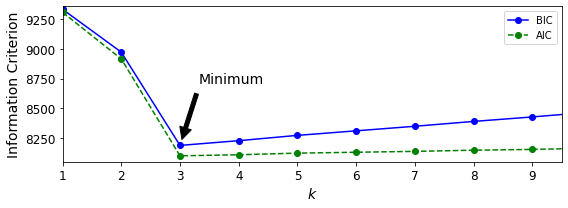

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
save_fig("aic_bic_vs_k_plot")
plt.show()

Busquemos la mejor combinación de valores tanto para el número de clústeres como para el hiperparámetro `covariance_type`:

In [ ]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [ ]:
best_k

3

In [ ]:
best_covariance_type

'full'

## Variational Bayesian Gaussian Mixtures

En lugar de buscar manualmente el número óptimo de grupos, es posible utilizar en su lugar la clase `BayesianGaussianMixture` que es capaz de dar pesos iguales (o cercanos) a grupos innecesarios. Simplemente configure el número de componentes en un valor que cree que es mayor que el número óptimo de clústeres, y el algoritmo eliminará los clústeres innecesarios automáticamente.

In [ ]:
from sklearn.mixture import BayesianGaussianMixture

In [ ]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

El algoritmo detectó automáticamente que solo se necesitan 3 componentes:

In [ ]:
np.round(bgm.weights_, 2)

array([0.4 , 0.  , 0.  , 0.  , 0.39, 0.2 , 0.  , 0.  , 0.  , 0.  ])

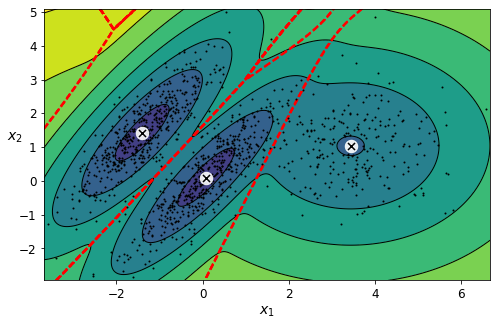

In [ ]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [ ]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=1000, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=1,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=10000,
                        weight_concentration_prior_type='dirichlet_process')

In [ ]:
np.round(bgm_low.weights_, 2)

array([0.49, 0.51, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [ ]:
np.round(bgm_high.weights_, 2)

array([0.43, 0.01, 0.01, 0.11, 0.01, 0.01, 0.01, 0.37, 0.01, 0.01])

Saving figure mixture_concentration_prior_plot


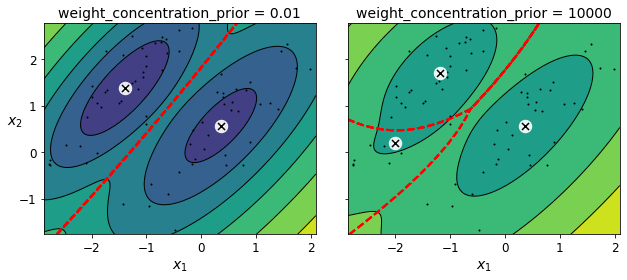

In [ ]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

save_fig("mixture_concentration_prior_plot")
plt.show()

Nota: el hecho de que vea solo 3 regiones en la gráfica correcta aunque haya 4 centroides no es un error. El peso del grupo superior derecho es mucho mayor que el peso del grupo inferior derecho, por lo que la probabilidad de que cualquier punto dado en esta región pertenezca al grupo superior derecho es mayor que la probabilidad de que pertenezca al grupo inferior derecho racimo.

In [ ]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [ ]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

Saving figure moons_vs_bgm_plot


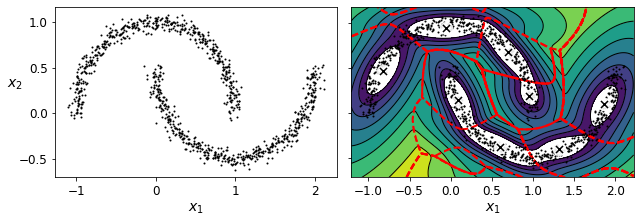

In [ ]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

save_fig("moons_vs_bgm_plot")
plt.show()

Bueno... en lugar de detectar 2 grupos en forma de luna, el algoritmo detectó 8 grupos elipsoidales. Sin embargo, el gráfico de densidad no se ve tan mal, por lo que podría ser utilizable para la detección de anomalías.

## Likelihood Function

In [ ]:
from scipy.stats import norm

In [ ]:
xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1)[:,np.newaxis] / (xx[1] - xx[0])

Saving figure likelihood_function_plot


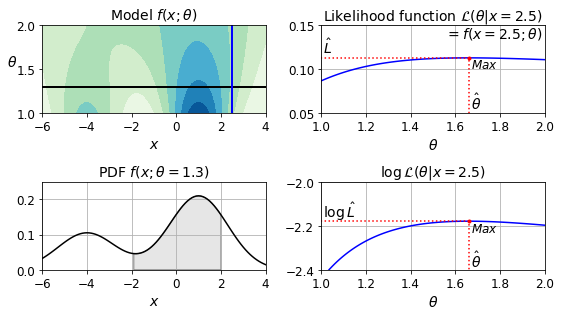

In [ ]:
from matplotlib.patches import Polygon

plt.figure(figsize=(8, 4.5))

x_idx = 85
s_idx = 30

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx]+ 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)

save_fig("likelihood_function_plot")
plt.show()

# Exercise solutions

## 1. to 9.

See Appendix A.

## 10. Cluster the Olivetti Faces Dataset

*Exercise: The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. Load the dataset using the `sklearn.datasets.fetch_olivetti_faces()` function.*

In [ ]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

In [ ]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [ ]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

*Exercise: Then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in each set.*

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [ ]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


To speed things up, we'll reduce the data's dimensionality using PCA:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

*Exercise: Next, cluster the images using K-Means, and ensure that you have a good number of clusters (using one of the techniques discussed in this chapter).*

In [ ]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


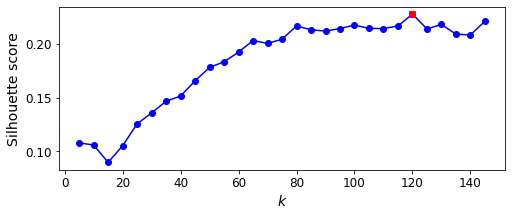

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [ ]:
best_k

120

It looks like the best number of clusters is quite high, at 120. You might have expected it to be 40, since there are 40 different people on the pictures. However, the same person may look quite different on different pictures (e.g., with or without glasses, or simply shifted left or right).

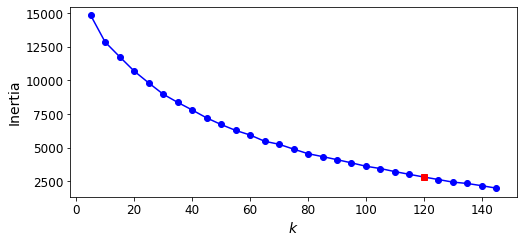

In [ ]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

The optimal number of clusters is not clear on this inertia diagram, as there is no obvious elbow, so let's stick with k=120.

In [ ]:
best_model = kmeans_per_k[best_index]

*Exercise: Visualize the clusters: do you see similar faces in each cluster?*

Cluster 0


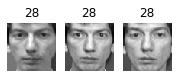

Cluster 1


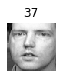

Cluster 2


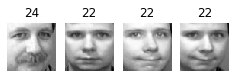

Cluster 3


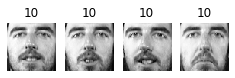

Cluster 4


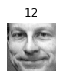

Cluster 5


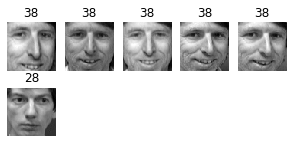

Cluster 6


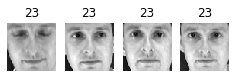

Cluster 7


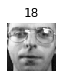

Cluster 8


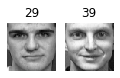

Cluster 9


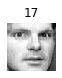

Cluster 10


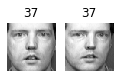

Cluster 11


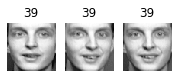

Cluster 12


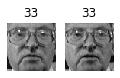

Cluster 13


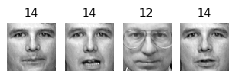

Cluster 14


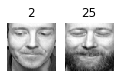

Cluster 15


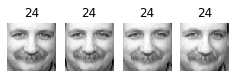

Cluster 16


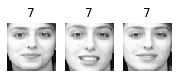

Cluster 17


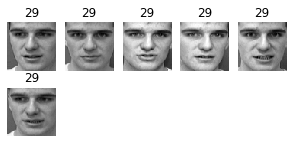

Cluster 18


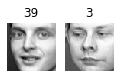

Cluster 19


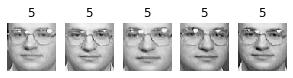

Cluster 20


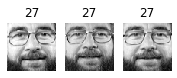

Cluster 21


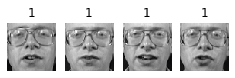

Cluster 22


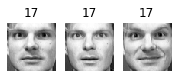

Cluster 23


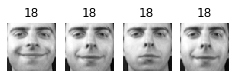

Cluster 24


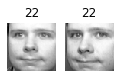

Cluster 25


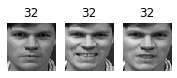

Cluster 26


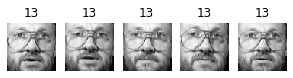

Cluster 27


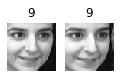

Cluster 28


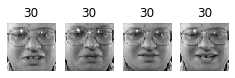

Cluster 29


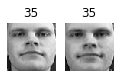

Cluster 30


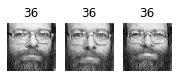

Cluster 31


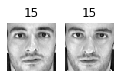

Cluster 32


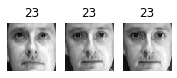

Cluster 33


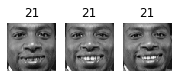

Cluster 34


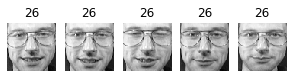

Cluster 35


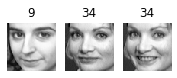

Cluster 36


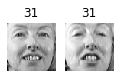

Cluster 37


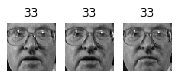

Cluster 38


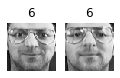

Cluster 39


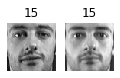

Cluster 40


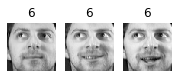

Cluster 41


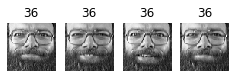

Cluster 42


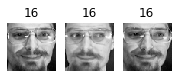

Cluster 43


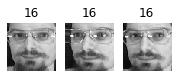

Cluster 44


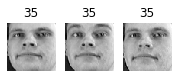

Cluster 45


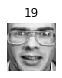

Cluster 46


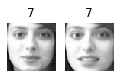

Cluster 47


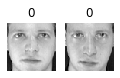

Cluster 48


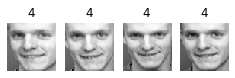

Cluster 49


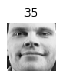

Cluster 50


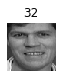

Cluster 51


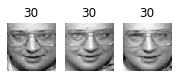

Cluster 52


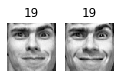

Cluster 53


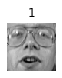

Cluster 54


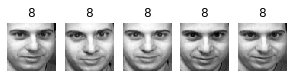

Cluster 55


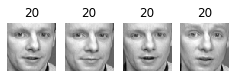

Cluster 56


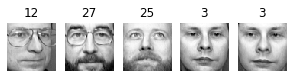

Cluster 57


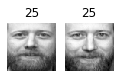

Cluster 58


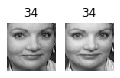

Cluster 59


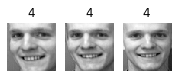

Cluster 60


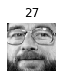

Cluster 61


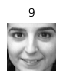

Cluster 62


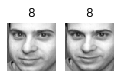

Cluster 63


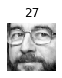

Cluster 64


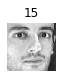

Cluster 65


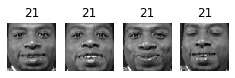

Cluster 66


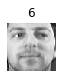

Cluster 67


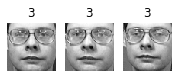

Cluster 68


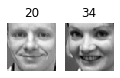

Cluster 69


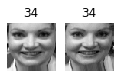

Cluster 70


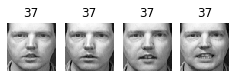

Cluster 71


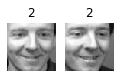

Cluster 72


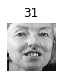

Cluster 73


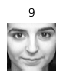

Cluster 74


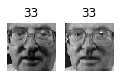

Cluster 75


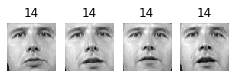

Cluster 76


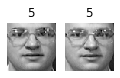

Cluster 77


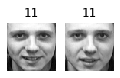

Cluster 78


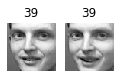

Cluster 79


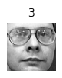

Cluster 80


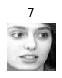

Cluster 81


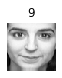

Cluster 82


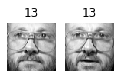

Cluster 83


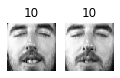

Cluster 84


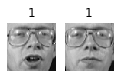

Cluster 85


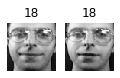

Cluster 86


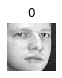

Cluster 87


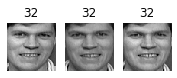

Cluster 88


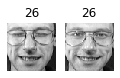

Cluster 89


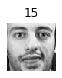

Cluster 90


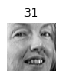

Cluster 91


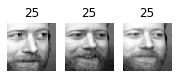

Cluster 92


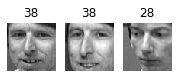

Cluster 93


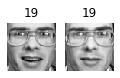

Cluster 94


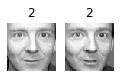

Cluster 95


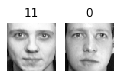

Cluster 96


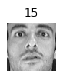

Cluster 97


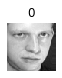

Cluster 98


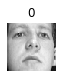

Cluster 99


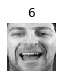

Cluster 100


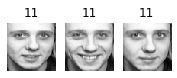

Cluster 101


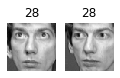

Cluster 102


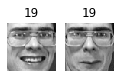

Cluster 103


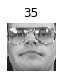

Cluster 104


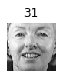

Cluster 105


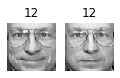

Cluster 106


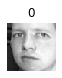

Cluster 107


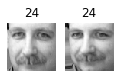

Cluster 108


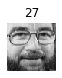

Cluster 109


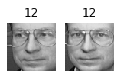

Cluster 110


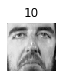

Cluster 111


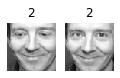

Cluster 112


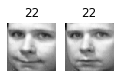

Cluster 113


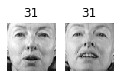

Cluster 114


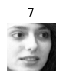

Cluster 115


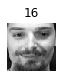

Cluster 116


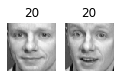

Cluster 117


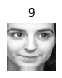

Cluster 118


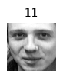

Cluster 119


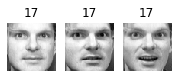

In [ ]:
def plot_faces(faces, labels, n_cols=5):
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face.reshape(64, 64), cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster].reshape(-1, 64, 64)
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

About 2 out of 3 clusters are useful: that is, they contain at least 2 pictures, all of the same person. However, the rest of the clusters have either one or more intruders, or they have just a single picture.

Clustering images this way may be too imprecise to be directly useful when training a model (as we will see below), but it can be tremendously useful when labeling images in a new dataset: it will usually make labelling much faster.

## 11. Using Clustering as Preprocessing for Classification

*Exercise: Continuing with the Olivetti faces dataset, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set.*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_pca, y_train)
clf.score(X_valid_pca, y_valid)

0.925

*Exercise: Next, use K-Means as a dimensionality reduction tool, and train a classifier on the reduced set.*

In [ ]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
    
clf.score(X_valid_reduced, y_valid)

0.7

Yikes! That's not better at all! Let's see if tuning the number of clusters helps.

*Exercise: Search for the number of clusters that allows the classifier to get the best performance: what performance can you reach?*

We could use a `GridSearchCV` like we did earlier in this notebook, but since we already have a validation set, we don't need K-fold cross-validation, and we're only exploring a single hyperparameter, so it's simpler to just run a loop manually:

In [ ]:
from sklearn.pipeline import Pipeline

for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=n_clusters)),
        ("forest_clf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_valid_pca, y_valid))

5 0.3625
10 0.55
15 0.6125
20 0.6625
25 0.6625
30 0.7
35 0.6875
40 0.7125
45 0.7
50 0.7375
55 0.7375
60 0.75
65 0.725
70 0.7375
75 0.7875
80 0.7125
85 0.725
90 0.775
95 0.7625
100 0.65
105 0.7125
110 0.725
115 0.7625
120 0.7625
125 0.725
130 0.775
135 0.7375
140 0.7375
145 0.725


Oh well, even by tuning the number of clusters, we never get beyond 80% accuracy. Looks like the distances to the cluster centroids are not as informative as the original images.

*Exercise: What if you append the features from the reduced set to the original features (again, searching for the best number of clusters)?*

In [ ]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

In [ ]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_extended, y_train)
clf.score(X_valid_extended, y_valid)

0.8125

That's a bit better, but still worse than without the cluster features. The clusters are not useful to directly train a classifier in this case (but they can still help when labelling new training instances).

## 12. A Gaussian Mixture Model for the Olivetti Faces Dataset

*Exercise: Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the algorithm, you should probably reduce the dataset's dimensionality (e.g., use PCA, preserving 99% of the variance).*

In [ ]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

*Exercise: Use the model to generate some new faces (using the `sample()` method), and visualize them (if you used PCA, you will need to use its `inverse_transform()` method).*

In [ ]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

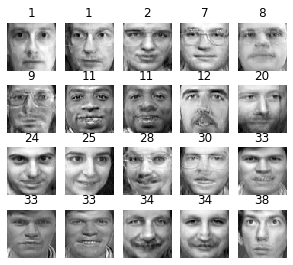

In [ ]:
plot_faces(gen_faces, y_gen_faces)

*Exercise: Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the `score_samples()` method for normal images and for anomalies).*

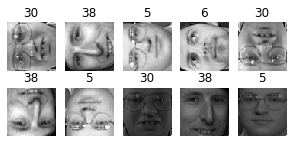

In [ ]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
darkened = darkened.reshape(-1, 64*64)
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [ ]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [ ]:
gm.score_samples(X_bad_faces_pca)

array([-2.43643150e+07, -1.89784991e+07, -3.78112161e+07, -4.98187638e+07,
       -3.20478804e+07, -1.37531031e+07, -2.92373904e+07, -1.05489264e+08,
       -1.19575656e+08, -6.74257782e+07])

The bad faces are all considered highly unlikely by the Gaussian Mixture model. Compare this to the scores of some training instances:

In [ ]:
gm.score_samples(X_train_pca[:10])

array([1163.0202095 , 1134.03637995, 1156.32132802, 1170.67602773,
       1141.45404783, 1154.35205193, 1091.32894533, 1111.41149431,
       1096.43048989, 1132.98982741])

## 13. Using Dimensionality Reduction Techniques for Anomaly Detection

*Exercise: Some dimensionality reduction techniques can also be used for anomaly detection. For example, take the Olivetti faces dataset and reduce it with PCA, preserving 99% of the variance. Then compute the reconstruction error for each image. Next, take some of the modified images you built in the previous exercise, and look at their reconstruction error: notice how much larger the reconstruction error is. If you plot a reconstructed image, you will see why: it tries to reconstruct a normal face.*

We already reduced the dataset using PCA earlier:

In [ ]:
X_train_pca

array([[ 3.78082848e+00, -1.85478747e+00, -5.14403582e+00, ...,
        -1.35635510e-01, -2.14079559e-01,  6.11926578e-02],
       [ 1.01488495e+01, -1.52754533e+00, -7.66978443e-01, ...,
         1.23931095e-01, -1.35269478e-01, -2.32696794e-02],
       [-1.00152884e+01,  2.87728882e+00, -9.19886231e-01, ...,
         7.26117715e-02, -2.96737882e-03,  1.24885648e-01],
       ...,
       [ 2.47586989e+00,  2.95597243e+00,  1.29985559e+00, ...,
        -2.09138989e-02,  3.48485485e-02, -1.54334918e-01],
       [-3.22031879e+00,  5.34897900e+00,  1.39427102e+00, ...,
         5.75523153e-02, -2.28309885e-01,  1.55576378e-01],
       [-9.22876537e-01, -3.64703059e+00,  2.26088119e+00, ...,
         1.36851206e-01, -6.91276789e-02,  6.26953915e-02]], dtype=float32)

In [ ]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [ ]:
reconstruction_errors(pca, X_train).mean()

0.00019205351

In [ ]:
reconstruction_errors(pca, X_bad_faces).mean()

0.0047073546

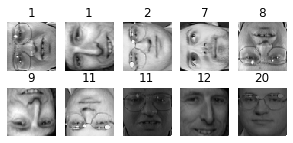

In [ ]:
plot_faces(X_bad_faces, y_gen_faces)

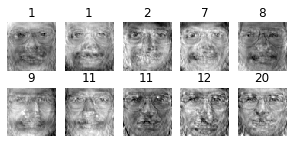

In [ ]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_gen_faces)